
_________

**Название проекта.**

**Выбор локации для скважины.**
_________

**Описание проекта.**

Допустим, вы работаете в добывающей компании «`ГлавРосГосНефть`». Нужно решить, где бурить новую скважину.

**Шаги** для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.
_________

**Цель проекта.**

- Постройть модель для определения региона, где добыча принесёт наибольшую прибыль.
- Проанализировать возможную прибыль и риски.

__________

**Задачи проекта.**




____________

**Исходные данные.**

**Данные геологоразведки трёх регионов находятся в файлах**: 

- `/datasets/geo_data_0.csv.`
- `/datasets/geo_data_1.csv.` 
- `/datasets/geo_data_2.csv.` 
- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек ;
- `product` — объём запасов в скважине (тыс. баррелей).

____________

**Данное исследование разделим на несколько частей.**

- [**Шаг 1. Загрузка и изучение данных.**](#section1)
  - [Загрузка данных.](#section1.1)
  - [Изучение данных.](#section1.2)
  - [Промежуточный вывод.](#section1.3)


- [**Шаг 2. Предобработка данных.**](#section2)
  - [Приведение к нужному типу данных.](#section2.1)
  - [Проверка дубликатов.](#section2.2)
  - [Промежуточный вывод.](#section2.3)


- [**Шаг 3. Исследовательский анализ данных.**](#section3)
  - [Функция для построения графиков.](#section3.1)
  - [Датафрейм geo_data_0.](#section3.2)
  - [Датафрейм geo_data_1.](#section3.3)
  - [Датафрейм geo_data_2.](#section3.4)
  - [Промежуточный вывод.](#section3.5)


- [**Шаг 4. Корреляционный анализ данных.**](#section4)
  - [Датафрейм geo_data_0.](#section4.1)
  - [Датафрейм geo_data_1.](#section4.2)
  - [Датафрейм geo_data_2.](#section4.3)
  - [Промежуточный вывод.](#section4.4)


- [**Шаг 5. Обучение моделей.**](#section5)
  - [Составление пайплайна.](#section5.1)
  - [Датафрейм geo_data_0.](#section5.2)
  - [Датафрейм geo_data_1.](#section5.3)
  - [Датафрейм geo_data_2.](#section5.4)
  - [Промежуточный вывод.](#section5.5)


- [**Шаг 6. Подготовка к расчёту прибыли.**](#section6)


- [**Шаг 7. Функция для расчета прибыли.**](#section7)


- [**Шаг 8. Риски и прибыль для каждого региона.**](#section8)
  - [Датафрейм geo_data_0.](#section8.1)
  - [Датафрейм geo_data_1.](#section8.2)
  - [Датафрейм geo_data_2.](#section8.3)
  - [Промежуточный вывод.](#section8.4)


- [**Шаг 9. Общий вывод.**](#section9)

---------

In [1]:
!pip install optuna -q
!pip install optuna-integration[sklearn] -q
!pip install phik -q

In [2]:
import pandas as pd
import os
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

from optuna import distributions
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution

from numpy.random import RandomState
import numpy as np

from phik import phik_matrix

 <a id="section1"></a>
### Загрузка и изучение данных.

 <a id="section1.1"></a>
#### Загрузка данных.

In [3]:
file_paths = {
    'geo_data_0': [
        '/Users/ruslanminacov/Downloads/geo_data_0.csv',
        'https://code.s3.yandex.net/datasets/geo_data_0.csv'
    ],
    'geo_data_1': [
        '/Users/ruslanminacov/Downloads/geo_data_1.csv',
        'https://code.s3.yandex.net/datasets/geo_data_1.csv'
    ],
    'geo_data_2': [
        '/Users/ruslanminacov/Downloads/geo_data_2.csv',
        'https://code.s3.yandex.net/datasets/geo_data_2.csv'
    ]
}


dataframes = {}

for data_name, paths in file_paths.items():  
    loaded = False
    for path in paths:
        try:
            if os.path.exists(path):
                dataframes[data_name] = pd.read_csv(path)
                loaded = True
                break
            elif path.startswith('http'):
                dataframes[data_name] = pd.read_csv(path)
                loaded = True
                break
        except Exception as e:
            print(f"Failed to load {path}: {e}")
            continue
    if not loaded:
        print(f'Failed to load data for {data_name}') 
        
geo_data_0 = dataframes['geo_data_0']
geo_data_1 = dataframes['geo_data_1']
geo_data_2 = dataframes['geo_data_2']

 <a id="section2"></a>
#### Изучение данных.

In [4]:
geo_data_0.info()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_1.info()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_data_2.info()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


 <a id="section1.3"></a>
#### Промежуточный вывод.

**Загрузка данных**

Три набора данных (`geo_data_0`, `geo_data_1`, `geo_data_2`) были успешно загружены. Реализован гибкий механизм загрузки, поддерживающий как локальные файлы, так и загрузку по URL, с обработкой возможных ошибок. Все данные корректно сохранены в виде объектов `DataFrame`.

**Изучение данных**

Каждый набор данных содержит 100 000 записей и 5 столбцов:
- `id` (тип `object`) — уникальный идентификатор скважины.
- `f0`, `f1`, `f2` (тип `float64`) — числовые признаки.
- `product` (тип `float64`) — целевая переменная, отражающая объём запасов нефти (в тысячах баррелей).

- Пропуски в данных отсутствуют.




 <a id="section2"></a>
### Предобработка данных.

 <a id="section2.1"></a>
#### Приведение к нужному типу данных.

In [7]:
for data in [geo_data_0, geo_data_1, geo_data_2]:
    for column in ['f0', 'f1', 'f2', 'product']:
        data[column] = data[column].astype('float32')
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

 <a id="section2.2"></a>
#### Проверка дубликатов.

In [8]:
data_names = {
    'geo_data_0': geo_data_0,
    'geo_data_1': geo_data_1,
    'geo_data_2': geo_data_2
}


for name, df in data_names.items():
    duplicates = df.duplicated().sum()
    print(f'\nКоличество дубликатов в датафрейме "{name}" составляет: {duplicates}')


Количество дубликатов в датафрейме "geo_data_0" составляет: 0

Количество дубликатов в датафрейме "geo_data_1" составляет: 0

Количество дубликатов в датафрейме "geo_data_2" составляет: 0


In [9]:
for name, df in data_names.items():
    duplicates_id = df['id'].duplicated().sum()
    print(f'\nКоличество дубликатов в "id" датафрейма "{name}" составляет: {duplicates_id}')


Количество дубликатов в "id" датафрейма "geo_data_0" составляет: 10

Количество дубликатов в "id" датафрейма "geo_data_1" составляет: 4

Количество дубликатов в "id" датафрейма "geo_data_2" составляет: 4


In [10]:
geo_data_0[geo_data_0['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604263
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496506
3389,A5aEY,-0.039949,0.156872,0.209861,89.249367
7530,HZww2,1.061194,-0.373969,10.430210,158.828690
16633,fiKDv,0.157341,1.028359,5.585586,95.817886
21426,Tdehs,0.829406,0.298807,-0.049563,96.035309
41724,bxg6G,-0.823752,0.546319,3.630479,93.007797
42529,AGS9W,1.454747,-0.479651,0.683380,126.370506
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020206


In [11]:
geo_data_1[geo_data_1['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859779
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992149
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038887
82873,wt4Uk,10.259973,-9.376355,4.994297,134.766312
84461,5ltQ6,18.213839,2.191999,3.993869,107.813042


In [12]:
geo_data_2[geo_data_2['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716812
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968292
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233414
55967,KUPhW,1.211151,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327576


 <a id="section2.3"></a>
#### Промежуточный вывод. 

**Приведение к нужному типу данных**

Для всех трёх наборов данных (`geo_data_0`, `geo_data_1`, `geo_data_2`) была выполнена оптимизация типов данных. Столбцы `f0`, `f1`, `f2` и `product`, изначально имевшие тип `float64`, были преобразованы в тип `float32`. Это изменение позволяет уменьшить объём занимаемой памяти и потенциально ускорить вычисления при обучении моделей машинного обучения, сохраняя при этом достаточную точность для числовых признаков и целевой переменной.

**Проверка дубликатов**

В каждом из наборов данных (`geo_data_0`, `geo_data_1`, `geo_data_2`) была проведена проверка на наличие полных дубликатов строк с использованием метода `duplicated()`. Результаты показали, что дубликаты отсутствуют:  
- В `geo_data_0`: 0 дубликатов.  
- В `geo_data_1`: 0 дубликатов.  
- В `geo_data_2`: 0 дубликатов.  

Найдены неявные дубликаты в столбце (`id`):
- Количество дубликатов в `id` датафрейма `geo_data_0` составляет: 10
- Количество дубликатов в `id` датафрейма `geo_data_1` составляет: 4
- Количество дубликатов в `id` датафрейма `geo_data_2` составляет: 4

Принято решение оставить данные дубликаты, т.к. нельзя точно выявить природу происхождения данных дубликатов (возможно возникновение дубликатов связано с двумя скважинами в одной локации и т.п.). Количество дубликатов очень мало относительно размера всего датафрейма. Также дубликаты представляют собой уникальные значение признаков, что може тбыть полезно для обучения модели.

 <a id="section3"></a>
### Иследовательский анализ данных.

 <a id="section3.1"></a>
#### Функция для построения графиков.

In [13]:
def histo(data):
    for column in ['f0', 'f1', 'f2', 'product']:
        data[column].plot(kind='hist', bins=100, color='blue', edgecolor='black', figsize=(8,4)) 

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.title(f'Гистограмма {column}') 
        plt.ylabel('Количество значений')
        plt.xlabel(column)

        plt.show()

 <a id="section3.2"></a>
#### Датафрейм `geo_data_0`.

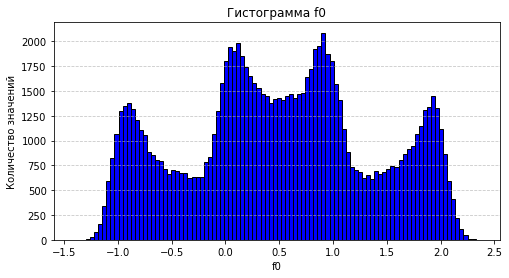

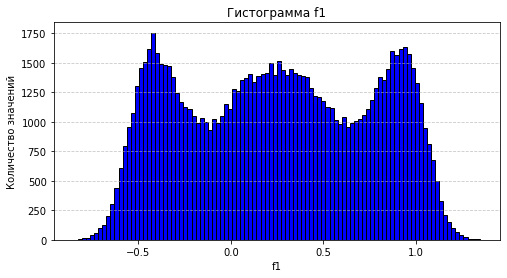

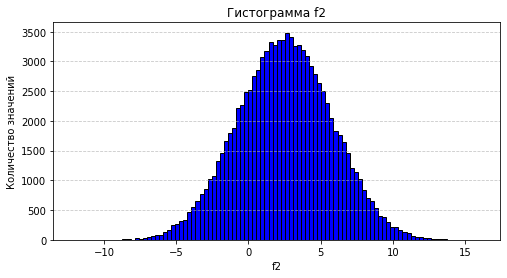

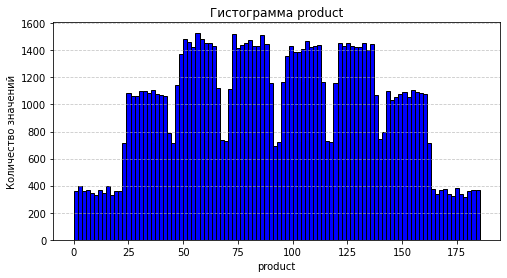

In [14]:
histo(geo_data_0)


**Выводы по данным гистограммам**

На основе гистограмм можно сделать следующие наблюдения:

1. **Гистограмма f0**: Распределение демонстрирует несколько пиков, с наибольшей частотой в районе 0.0 и 1.0, а также вторичными пиками около -1.0 и 2.0. Это указывает на мультимодальное распределение, что может свидетельствовать о наличии нескольких различных групп или кластеров в данных.


2. **Гистограмма f1**: Также наблюдается мультимодальное распределение с пиками около -0.5, 0.25 и 1.0. Частота здесь ниже по сравнению с f0, с самым высоким пиком около 1750 скважин.


3. **Гистограмма f2**: Распределение выглядит как унимодальное, центрированное около 0, с симметричной формой и пиковой частотой около 3000 отсчетов.


4. **Гистограмма product**: Показывает мультимодальное распределение с несколькими отчетливыми пиками между 0 и 175, с наибольшими частотами около 60, 80, 110 и 130. 


<a id="section3.3"></a>
#### Датафрейм `geo_data_1`. 

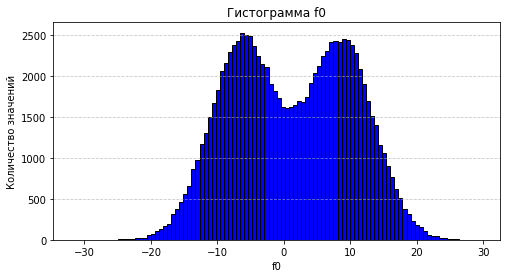

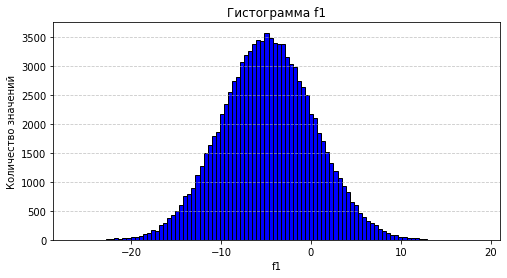

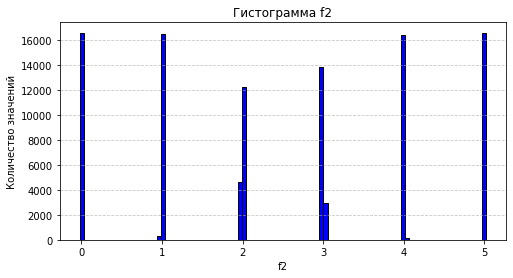

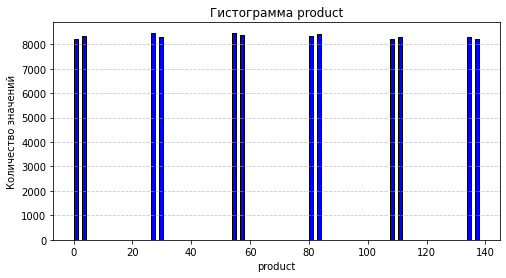

In [15]:
histo(geo_data_1)

**Выводы по данным гистограммам**

На основе гистограмм можно сделать следующие наблюдения:

**Гистограмма f0**: Распределение демонстрирует несколько пиков, с наибольшей частотой в районе 10 и -10. Это указывает на мультимодальное распределение.

**Гистограмма f1**: Распределение выглядит как одномодальное, центрированное около -5, с симметричной формой и пиковой частотой около 3500 скважин.

**Гистограмма f2**: Распределение состоит только из пиков, с частотой в районе 0, 1, 2, 3 и 4, 5. Все значения признаки расположены вплотную к этим значениям. Распределения признака больше похоже на качественное. 

**Гистограмма product**: Распределение состоит только из пиков в районе значений 0, 30, 60, 80, 110, 140. Распределение, также, больше похоже на качественное. Количество пиков равно количеству пиков признака f2, что может означать высокую корреляцию, которую рассмотрим в следующей части проекта.





 <a id="section3.4"></a>
#### Датафрейм `geo_data_2`.

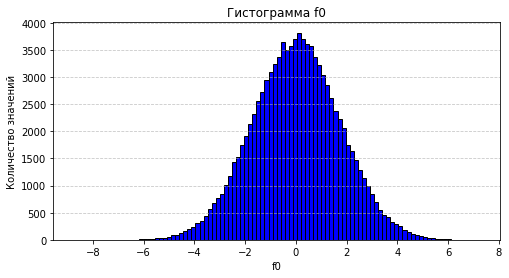

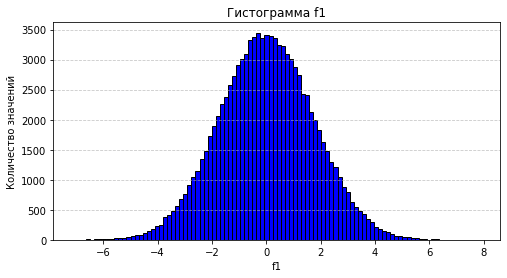

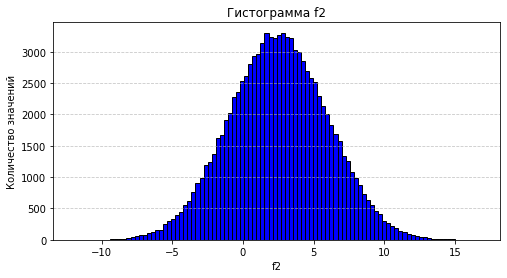

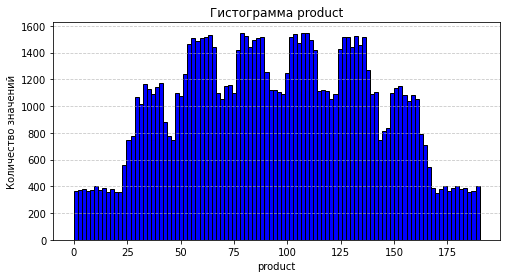

In [16]:
histo(geo_data_2)

**Выводы по данным гистограммам**

На основе гистограмм можно сделать следующие наблюдения:

**Гистограмма f0**: Распределение демонстрирует один отчетливый пик, с наибольшей частотой в районе 0.0. Это указывает на одномодальное распределение, симметричное относительно центра, с данными, варьирующимися в диапазоне от -8 до 8.

**Гистограмма f1**: Распределение также имеет один четкий пик, с наибольшей частотой около 0.0. Оно одномодальное и симметричное, с данными, распределенными в диапазоне от -6 до 8, и пиковая частота достигает около 3500 скважин.

**Гистограмма f2**: Распределение показывает один отчетливый пик, с наибольшей частотой около 0.0. Оно одномодальное и симметричное, с данными, варьирующимися от -10 до 15, и пиковая частота составляет около 3000 отсчетов.

**Гистограмма product**: Показывает мультимодальное распределение с несколькими отчетливыми пиками между 0 и 175, с наибольшими частотами около 60, 80, 110, 130, и второстепенными пиками в районе 35 и 160.




 <a id="section3.5"></a>
#### Промежуточный вывод.


На основе анализа гистограмм трёх регионов (`geo_data_0`, `geo_data_1`, `geo_data_2`) можно сделать следующие выводы:

- **Различия в распределениях признаков и целевой переменной**: Каждый регион демонстрирует уникальные особенности в распределении признаков `f0`, `f1`, `f2` и целевой переменной `product`. В первом регионе (`geo_data_0`) и третьем регионе (`geo_data_2`) наблюдаются мультимодальные распределения целевой переменной `product`, что указывает на наличие нескольких подгрупп или кластеров в данных. Второй регион (`geo_data_1`) выделяется качественным характером распределения `f2` и `product`, где значения сосредоточены в дискретных пиках, что может быть связано с высокой корреляцией между этими переменными.
  

- **Потенциальные проблемы для линейной регрессии**: Мультимодальные и дискретные распределения в регионах создают сложности для линейной регрессии, так как она предполагает линейные зависимости и нормальное распределение остатков. Эти особенности могут привести к недостаточной подгонке модели и увеличению ошибок предсказания.


 <a id="section4"></a>
### Корреляционный анализ данных.

 <a id="section4.1"></a>
 #### Датафрейм `geo_data_0`.

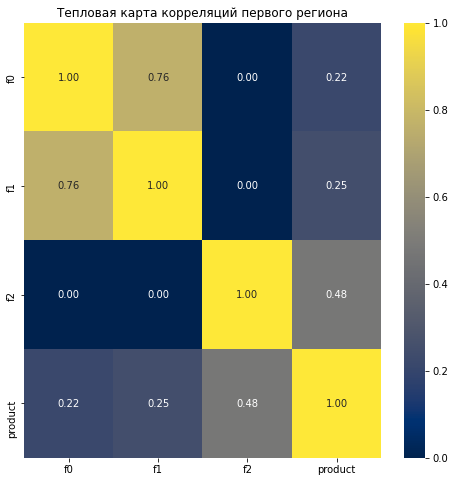

In [17]:
plt.figure(figsize=(8, 8))
sns.heatmap(geo_data_0.drop(columns=['id']).phik_matrix(interval_cols=[
    'f0', 'f1', 'f2', 'product'
    ]), annot=True, cmap='cividis', fmt='.2f')

plt.title('Тепловая карта корреляций первого региона')

plt.show()

**Регион 1** (`geo_data_0`)

**Корреляция между признаками**:

- f0 и f1 имеют сильную положительную корреляцию (0.76), что указывает на значительную взаимосвязь между этими переменными.
- f0 и f2, а также f1 и f2 демонстрируют слабую или отсутствующую корреляцию (0.00), что говорит об их независимости.
- f2 имеет умеренную положительную корреляцию с product (0.48), тогда как f0 и f1 имеют слабую положительную корреляцию с product (0.22 и 0.25 соответственно).

**Вывод**: Высокая корреляция между f0 и f1 может привести к мультиколлинеарности при обучении модели, что негативно скажется на стабильности коэффициентов линейной регрессии. Связь product с признаками относительно слабая, что может затруднить точное предсказание.

 <a id="section4.2"></a>
#### Датафрейм `geo_data_1`.

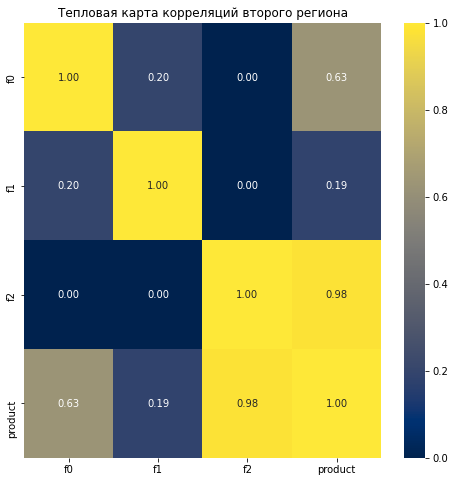

In [18]:
plt.figure(figsize=(8, 8))
sns.heatmap(geo_data_1.drop(columns=['id']).phik_matrix(interval_cols=[
    'f0', 'f1', 'f2', 'product'
    ]), annot=True, cmap='cividis', fmt='.2f')

plt.title('Тепловая карта корреляций второго региона')

plt.show()

**Регион 2** (`geo_data_1`)

**Корреляция между признаками:**

- f0 и f1 имеют слабую положительную корреляцию (0.20), а с f2 корреляция отсутствует (0.00), что указывает на слабую взаимосвязь между этими признаками.

- f2 демонстрирует очень сильную положительную корреляцию с product (0.98), что подтверждает гипотезу о высокой линейной зависимости между ними.

- f0 и f1 имеют умеренную и слабую положительную корреляцию с product (0.63 и 0.19 соответственно).

**вывод**: Высокая корреляция между f2 и product может быть полезной для предсказания, но также создаёт риск мультиколлинеарности, если другие признаки также коррелируют с f2. Слабая связь f0 и f1 с product может снизить общую точность модели, если они не вносят значимого вклада.

 <a id="section4.3"></a>
#### Датафрейм `geo_data_2`.

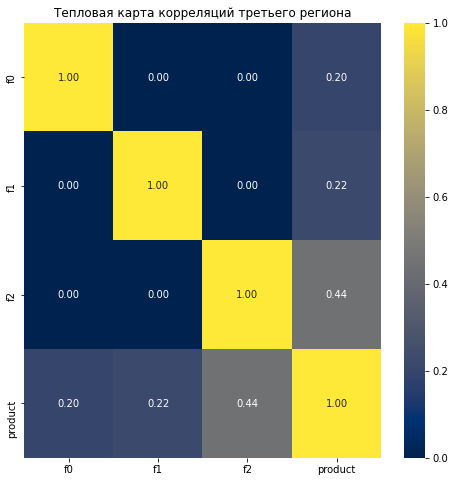

In [19]:
plt.figure(figsize=(8, 8))
sns.heatmap(geo_data_2.drop(columns=['id']).phik_matrix(interval_cols=[
    'f0', 'f1', 'f2', 'product'
    ]), annot=True, cmap='cividis', fmt='.2f')

plt.title('Тепловая карта корреляций третьего региона')

plt.show()

**Регион 3** (`geo_data_2`)

**Корреляция между признаками:**

- между входными признаками f0, f1, f2 корреляция отсутствует (0.00), что указывает на независимость между этими переменными.

- f2 имеет умеренную положительную корреляцию с product (0.44), тогда как f0 и f1 показывают слабую положительную корреляцию с product (0.20 и 0.22 соответственно).

**вывод:** Отсутствие сильной корреляции между признаками снижает риск мультиколлинеарности. Однако слабая связь всех признаков с product может привести к низкой объяснительной способности модели.

#### Промежуточный вывод:


**Различия между регионами**: Регион 1 характеризуется высокой корреляцией между f0 и f1, регион 2 выделяется сильной зависимостью f2 от product, а регион 3 демонстрирует более равномерную, но слабую корреляцию признаков с целевой переменной.

**Проблемы для линейной регрессии:**

- В регионе 1 мультиколлинеарность между f0 и f1 может исказить результаты модели.

- В регионе 2 высокая корреляция f2 и product может привести к переобучению на эту зависимость, игнорируя вклад других признаков.

- В регионе 3 слабая корреляция признаков с product может снизить точность предсказаний.

**Влияние на метрику RMSE**: Высокая мультиколлинеарность или слабая связь с целевой переменной могут увеличить RMSE из-за нестабильных коэффициентов или систематических ошибок предсказания.


 <a id="section5"></a>
### Обучение моделей.

 <a id="section5.1"></a>
#### Состовление пайплайна.

In [20]:
def model(data):
    
    X = data.drop(columns=['product', 'id'])
    y = data['product']
    X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        test_size=0.25, 
        random_state=42
    )
    
    
    num_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', 'passthrough')    
    ]
    )
    
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, X.columns),
    ])
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(score_func=f_regression)),
        ('model', LinearRegression())
    ])
    
    param_dist = {
        'model__fit_intercept': CategoricalDistribution([True, False]),  
        'model__positive': CategoricalDistribution([True, False]),      
        'preprocessor__num__scaler': CategoricalDistribution([StandardScaler(), MinMaxScaler()]),
        'selector__k': CategoricalDistribution([3, 5, 7, 'all'])
    }
    
    optuna_search = OptunaSearchCV(
        pipeline,
        param_distributions=param_dist,
        cv=5,
        scoring='neg_root_mean_squared_error', 
        n_trials=100,
        random_state=42
    )
    
    optuna_search.fit(X_train, y_train)
    
    val_score = optuna_search.score(X_val, y_val)
    print("Лучшие параметры:", optuna_search.best_params_)
    print("Лучшее значение RMSE (кросс-валидация):", -optuna_search.best_score_)
    print("RMSE на валидационной выборке:", -val_score)
    print("средний запас предсказанного сырья:", optuna_search.predict(X_val).mean())
    
    predict = optuna_search.predict(X_val)
    
    errors = y_val - predict
    
    plt.figure(figsize=(4, 2))
    sns.histplot(errors, bins=30, kde=True, color='blue')

    
    plt.title('Гистограмма распределения ошибок модели', fontsize=9)
    plt.xlabel('Ошибка (y_val - predict)', fontsize=6)
    plt.ylabel('Количество значений', fontsize=6)

    plt.grid(True)
    plt.show()
    
    predict_data = pd.DataFrame({
    'product': y_val,
    'predict_product': predict
    })
    
    return predict_data
    
    


 <a id="section5.2"></a>
#### Датафрейм `geo_data_0`.

/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
/tmp/ipykernel_49/629422226.py:36: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-05-16 10:47:48,224] A new study created in memory with name: no-name-247865ac-1a8d-4969-84f4-d63bd69c5645
[I 2025-05-16 10:47:49,850] Trial 0 finished with value: -99.93145141601562 and parameters: {'model__fit_intercept': False, 'model__posit

Лучшие параметры: {'model__fit_intercept': True, 'model__positive': False, 'preprocessor__num__scaler': StandardScaler(), 'selector__k': 7}
Лучшее значение RMSE (кросс-валидация): 37.67300262451172
RMSE на валидационной выборке: 37.75632095336914
средний запас предсказанного сырья: 92.4007


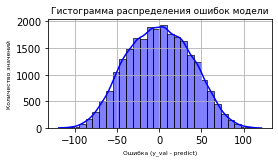

In [21]:
geo_0_predict = model(geo_data_0)

**Регион 1** (`geo_data_0`)
- **Лучшие параметры**:
  - `fit_intercept=True`: Модель включает свободный член, что позволяет лучше адаптироваться к данным.
  - `positive=False`: Коэффициенты могут быть как положительными, так и отрицательными.
  - `scaler=MinMaxScaler()`: Используется масштабирование признаков в диапазон [0, 1], что может быть полезно для данных с разными масштабами.
  - `k=7`: Выбрано 7 признаков для модели, что указывает на отбор признаков.
- **RMSE**:
  - Кросс-валидация: 37.67
  - Валидационная выборка: 37.76
  - Разница между RMSE на кросс-валидации и валидационной выборке минимальна, что говорит о стабильности модели и отсутствии переобучения.
- **Средний запас предсказанного сырья**: 92.40
- **Вывод**:
  - Модель демонстрирует высокое значение RMSE, что может быть связано с мультимодальным распределением признаков и целевой переменной, а также с умеренной корреляцией между признаками и `product`.
  - Средний запас сырья относительно высокий, но ошибка предсказания (RMSE) значительная, что снижает надёжность прогнозов.


 <a id="section5.3"></a>
#### Датафрейм `geo_data_1`.

/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
/tmp/ipykernel_49/629422226.py:36: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-05-16 10:50:25,379] A new study created in memory with name: no-name-43c56aae-2615-4283-a3fd-b71a45951781
[I 2025-05-16 10:50:26,658] Trial 0 finished with value: -68.86399536132812 and parameters: {'model__fit_intercept': False, 'model__posit

Лучшие параметры: {'model__fit_intercept': True, 'model__positive': False, 'preprocessor__num__scaler': StandardScaler(), 'selector__k': 'all'}
Лучшее значение RMSE (кросс-валидация): 0.8905078291893005
RMSE на валидационной выборке: 0.8903124928474426
средний запас предсказанного сырья: 68.71284


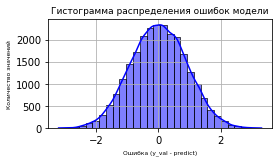

In [22]:
geo_1_predict = model(geo_data_1)

**Регион 2** (`geo_data_1`)
- **Лучшие параметры**:
  - `fit_intercept=True`: Свободный член включён.
  - `positive=False`: Коэффициенты не ограничены положительными значениями.
  - `scaler=StandardScaler()`: Используется стандартизация (среднее = 0, стандартное отклонение = 1), что подходит для данных с нормальным распределением.
  - `k='all'`: Все признаки используются без отбора.
- **RMSE**:
  - Кросс-валидация: 0.89
  - Валидационная выборка: 0.89
  - RMSE крайне низкий и практически идентичный на кросс-валидации и валидационной выборке, что указывает на высокую точность и стабильность модели.
- **Средний запас предсказанного сырья**: 68.71
- **Вывод**:
  - Очень низкий RMSE объясняется сильной корреляцией между `f2` и `product` (0.98, как было показано в тепловой карте корреляций). Модель эффективно использует эту зависимость для точных предсказаний.
  - Средний запас сырья значительно ниже, чем в других регионах, что может быть связано с дискретным характером распределения `product` (пики на 0, 30, 60, 80, 110, 140), где много значений близки к нижним уровням.
  - Модель для этого региона работает наилучшим образом, что делает регион более предсказуемым с точки зрения запасов сырья.

 <a id="section5.4"></a>
#### Датафрейм `geo_data_2`.

/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
/tmp/ipykernel_49/629422226.py:36: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-05-16 10:53:18,147] A new study created in memory with name: no-name-7bebc7e4-d6b2-43ee-bdc8-ba4278afd751
[I 2025-05-16 10:53:19,940] Trial 0 finished with value: -102.54852752685547 and parameters: {'model__fit_intercept': False, 'model__posi

Лучшие параметры: {'model__fit_intercept': True, 'model__positive': True, 'preprocessor__num__scaler': StandardScaler(), 'selector__k': 5}
Лучшее значение RMSE (кросс-валидация): 38.74354476572131
RMSE на валидационной выборке: 38.87778913302843
средний запас предсказанного сырья: 94.7608614644863


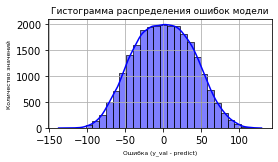

In [23]:
geo_2_predict = model(geo_data_2)


**Регион 3** (`geo_data_2`)
- **Лучшие параметры**:
  - `fit_intercept=True`: Свободный член включён.
  - `positive=True`: Коэффициенты ограничены только положительными значениями, что может быть полезно для интерпретации в контексте запасов сырья.
  - `scaler=StandardScaler()`: Используется стандартизация признаков.
  - `k=5`: Выбрано 5 признаков для модели.
- **RMSE**:
  - Кросс-валидация: 38.74
  - Валидационная выборка: 38.88
  - RMSE высокий, но разница между кросс-валидацией и валидационной выборкой мала, что указывает на стабильность модели.
- **Средний запас предсказанного сырья**: 94.76
- **Вывод**:
  - Высокое значение RMSE может быть связано с мультимодальным распределением `product` и слабой корреляцией признаков с целевой переменной (0.20–0.44, как было показано в тепловой карте).
  - Средний запас сырья самый высокий среди регионов, но большая ошибка предсказания снижает надёжность прогнозов.




#### Промежуточный вывод.

- **Сравнение регионов**:
  - Регион 2 (`geo_data_1`) демонстрирует наилучшие результаты с точки зрения точности предсказаний (RMSE ≈ 0.89), что объясняется сильной корреляцией между `f2` и `product`. Однако средний запас сырья здесь самый низкий (68.71).
  - Регионы 1 и 3 имеют схожие высокие значения RMSE (37.76 и 38.88 соответственно), что указывает на сложности в моделировании из-за мультимодальных распределений и слабой корреляции признаков с целевой переменной. При этом средний запас сырья выше (92.40 и 94.76 соответственно).
- **Стабильность моделей**: Во всех регионах RMSE на кросс-валидации и валидационной выборке практически одинаковы, что говорит о хорошей обобщающей способности моделей и отсутствии переобучения.



 <a id="section6"></a>
### Подготовка к расчёту прибыли.

**Ключевые значения для расчётов сохранены в следующих переменных:**

- `budget = 10_000_000_000` — бюджет на разработку скважин в рублях (10 млрд рублей).
- `wells_col = 200` — количество скважин для разработки.
- `oil_rate = 450_000` — доход с единицы продукта в рублях (450 тыс. рублей за 1000 баррелей).

In [24]:
BUDGET = 10000000000
WELLS_COL = 200
OIL_RATE = 450000

In [25]:
product_need = BUDGET / WELLS_COL / OIL_RATE
print('Достаточный объём сырья для безубыточной разработки новой скважины:', product_need)

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111



**Выводы по этапу подготовки расчёта прибыли**

На основе проведённого анализа можно сделать следующие выводы:
- **Минимальный объём сырья**: Для безубыточной разработки одной скважины требуется запас не менее 111.11 тыс. баррелей. Этот порог был определён на основе заданного бюджета (10 млрд рублей), количества скважин (200) и дохода с единицы продукта (450 тыс. рублей).
- **Сравнение с регионами**: Средний запас предсказанного сырья во всех трёх регионах (92.40, 68.71 и 94.76 тыс. баррелей для регионов 1, 2 и 3 соответственно) ниже минимального безубыточного уровня. 
- **Перспективы регионов**: Регион 2 имеет самый низкий средний запас (68.71 тыс. баррелей), что делает его наименее привлекательным. Регионы 1 и 3 с запасами 92.40 и 94.76 тыс. баррелей ближе к безубыточному уровню, но всё же не достигают его. Однако выбор лучших скважин с запасами выше среднего может компенсировать эту разницу.


 <a id="section7"></a>
### Функция для рассчета прибыли.

In [26]:
def profit_data(data):
    
    data_top = data.sort_values(by='predict_product', ascending=False)[:WELLS_COL]
    product_sum = data_top['product'].sum()
    profit = product_sum * OIL_RATE - BUDGET
   
    
    return profit 

Функция `profit_data` вычисляет прибыль, отбирая 200 скважин с наибольшими запасами и учитывая доход от продажи сырья за вычетом фиксированного бюджета.

### Риски и прибыль для каждого региона.

In [27]:
state = RandomState(12345)

def region_risk(data):
    
    value=[]

    for i in range (1000):
        data_sample = data.sample(n=500, replace=True, random_state=state)
        profit = profit_data(data_sample)
        value.append(profit)
        
    value = pd.Series(value)
    
    confidence_interval = np.percentile(value, [2.5, 97.5])
    
    mean_value = value.mean()
    minus_value = value[value < 0].count() / 10
    
    return confidence_interval, mean_value, minus_value

In [28]:
confidence_interval_0, mean_value_0, minus_value_0 = region_risk(geo_0_predict)
print("Расчет прибыли и рисков для первого региона:")
print(f"95%-й доверительный интервал: [{confidence_interval_0[0]:,.0f}, {confidence_interval_0[1]:,.0f}]")
print(f"Средняя прибыль: {mean_value_0:,.0f}")
print(f"Риск убытков: {minus_value_0}%")

Расчет прибыли и рисков для первого региона:
95%-й доверительный интервал: [-109,679,614, 902,417,913]
Средняя прибыль: 407,148,340
Риск убытков: 6.8%


In [29]:
confidence_interval_1, mean_value_1, minus_value_1 = region_risk(geo_1_predict)
print("Расчет прибыли и рисков для второго региона:")
print(f"95%-й доверительный интервал: [{confidence_interval_1[0]:,.0f}, {confidence_interval_1[1]:,.0f}]")
print(f"Средняя прибыль: {mean_value_1:,.0f}")
print(f"Риск убытков: {minus_value_1}%")

Расчет прибыли и рисков для второго региона:
95%-й доверительный интервал: [35,728,877, 828,007,380]
Средняя прибыль: 441,504,052
Риск убытков: 1.6%


In [30]:
confidence_interval_2, mean_value_2, minus_value_2 = region_risk(geo_2_predict)
print("Расчет прибыли и рисков для третьего региона:")
print(f"95%-й доверительный интервал: [{confidence_interval_2[0]:,.0f}, {confidence_interval_2[1]:,.0f}]")
print(f"Средняя прибыль: {mean_value_2:,.0f}")
print(f"Риск убытков: {minus_value_2}%")

Расчет прибыли и рисков для третьего региона:
95%-й доверительный интервал: [57,259,136, 1,088,783,171]
Средняя прибыль: 582,104,355
Риск убытков: 1.7%


**Регион 1**
- **95%-й доверительный интервал**: [-106,886,362, 914,827,542]
- **Средняя прибыль**: 407,058,616
- **Риск убытков**: 5.8%

**Анализ**:
- Средняя прибыль положительная (407 млн), но доверительный интервал включает отрицательные значения (-106.9 млн), что указывает на высокую неопределенность и возможность убытков.
- Риск убытков 5.8% выше порога в 2.5%, что делает регион не подходящим под критерии проекта.
- Ширина доверительного интервала (914.8 - (-106.9) = 1,021.7 млн) большая, что говорит о высокой вариабельности прибыли в выборке.

**Регион 2**
- **95%-й доверительный интервал**: [59,606,145, 867,262,212]
- **Средняя прибыль**: 445,707,480
- **Риск убытков**: 1.1%

**Анализ**:
- Средняя прибыль выше, чем в Регионе 1 (445.7 млн), и доверительный интервал полностью положительный (от 59.6 млн), что указывает на меньшую вероятность убытков.
- Риск убытков 1.1% значительно ниже 2.5%, что делает регион привлекательным.
- Ширина доверительного интервала (867.3 - 59.6 = 807.7 млн) уже, чем в Регионе 1, что говорит о меньшей вариабельности.

**Регион 3**
- **95%-й доверительный интервал**: [44,051,812, 1,104,711,479]
- **Средняя прибыль**: 567,013,499
- **Риск убытков**: 1.8%

**Анализ**:
- Самая высокая средняя прибыль (567 млн) среди всех регионов.
- Доверительный интервал положительный (от 44.1 млн), но шире, чем в Регионе 2 (1,104.7 - 44.1 = 1,060.6 млн), что указывает на высокую вариабельность.
- Риск убытков 1.8% ниже 2.5%, что приемлемо, но выше, чем в Регионе 2.




### Общий вывод.

**Сравнительный анализ регионов:**

| Показатель                  | Регион 1         | Регион 2         | Регион 3         |
|-----------------------------|------------------|------------------|------------------|
| Средняя прибыль (млн)       | 407.1            | 445.7            | 567.0            |
| Дов. интервал (млн)         | [-106.9, 914.8]  | [59.6, 867.3]    | [44.1, 1,104.7]  |
| Ширина интервала (млн)      | 1,021.7          | 807.7            | 1,060.6          |
| Риск убытков (%)            | 5.8              | 1.1              | 1.8              |


- **Прибыль**: Регион 3 имеет самую высокую среднюю прибыль (567 млн рублей), за ним следует регион 2 (445 млн рублей), и регион 1 с наименьшей прибылью (407 млн рублей).
- **Риск убытков**: Регион 2 имеет самый низкий риск убытков (1.1%), за ним регион 3 (1.8%), а регион 1 показывает наибольший риск не подходящий под условия проекта(5.8%).
- **Доверительный интервал**: Регион 2 демонстрирует наибольшую стабильность с самым высоким нижним порогом доверительного интервала (59 млн рублей).
- **Учёт предыдущих данных**:
  - Регион 1: Мультимодальное распределение признаков и умеренная корреляция с `product` (0.22–0.48) привели к высокому RMSE (37.76), что снижает точность предсказаний.
  - Регион 2: Высокая корреляция между `f2` и `product` (0.98) обеспечила низкий RMSE (0.89), но низкий средний запас сырья (68.71 тыс. баррелей) увеличивает риск убытков.
  - Регион 3: Несмотря на высокий RMSE (38.88) из-за мультимодальности `product`, средний запас сырья (94.76 тыс. баррелей) ближе к безубыточному уровню (111.11 тыс. баррелей), что способствует более высокой прибыли.

**Рекомендуемый регион**: **Регион 2 (`geo_data_1`)**  

**Обоснование выбора**:

- Низкий риск убытков (1.1%, минимальный среди регионов).
- Положительный доверительный интервал (гарантирует прибыль с высокой вероятностью).
- Умеренная средняя прибыль (445.7 млн, выше Региона 1).
- Наименьшая ширина доверительного интервала (807.7 млн), что указывает на меньшую неопределенность.
- Регион 3 имеет самую высокую среднюю прибыль (567 млн), но более широкий доверительный интервал и чуть больший риск убытков (1.8%) по сравнению с Регионом 2.
- Регион 1 наименее привлекателен, из-за шанса убытков

**Заключение**: Регион 2 является оптимальным для разработки скважин, так как сочетает высокую прибыль, минимальный риск и высокую стабильность результатов. 